In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from keras import models, layers
import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
import tensorflow as tf

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from matplotlib import style

import cv2
import random as rn
import os

In [3]:
X = []
TEMP = []
projectDir = '/content/drive/MyDrive/MACS/6505/Project'
IMG_SIZE = 224
nImagesOrg = projectDir + "/assets/normal/"
pImagesOrg = projectDir + "/assets/potholes/"

In [4]:
def process_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            TEMP.append(str(label))
        except:
            pass

In [5]:
process_data('NORMAL',nImagesOrg)

100%|██████████| 352/352 [01:42<00:00,  3.42it/s]


In [6]:
process_data('POTHOLE',pImagesOrg)

100%|██████████| 329/329 [01:40<00:00,  3.26it/s]


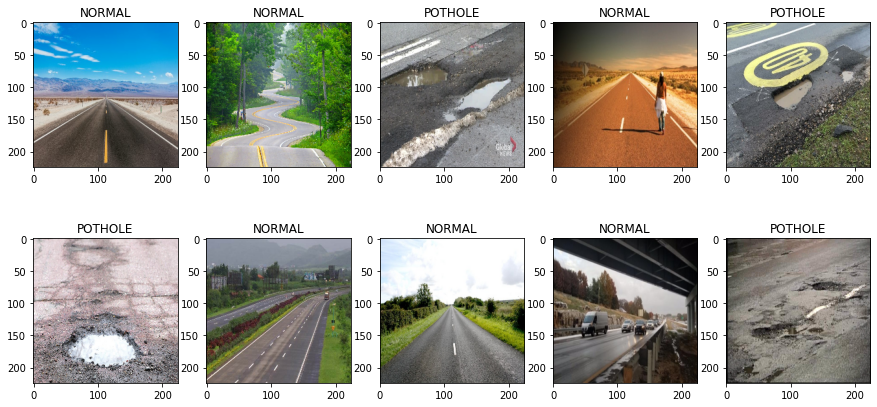

In [7]:
fig,ax = plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l = rn.randint(0,len(TEMP))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(TEMP[l])
        ax[i,j].set_aspect('equal')

In [8]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(TEMP)
Y = to_categorical(Y,2)
print(Y)
X = np.array(X)
X = X/255
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
X_train.shape

(510, 224, 224, 3)

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [11]:
data_generator = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            shear_range=0.1,
            zoom_range=0.2)
data_generator.fit(X_train) 

In [12]:
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, BatchNormalization, Dropout

class RESNet(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(ResNet50(include_top=False, input_shape=input_shape, pooling='avg'))
        self.add(layers.Flatten())
        self.add(layers.Dense(units=4096, activation='relu')) 
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(units=4096, activation='relu')) 
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(units=num_classes, activation='softmax'))  
        
        self.compile(loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(5)], optimizer=Adam(lr=5e-4))

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
batch_size = 12
n_epochs = 30
model = RESNet(input_shape, num_classes)
model_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size, 
                    epochs=n_epochs, validation_data=(X_test, y_test), callbacks=[reduce_lr])
test_score = model.evaluate(X_test, y_test, batch_size=32)
print()
print('Test loss:', test_score[0]) 
print('Test accuracy:', test_score[1])

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/30
42/42 [==============================] - 382s 9s/step - loss: 1.0745 - accuracy: 0.7828 - top_k_categorical_accuracy: 1.0000 - val_loss: 1848.8107 - val_accuracy: 0.4941 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
42/42 [==============================] - 373s 9s/step - loss: 0.3448 - accuracy: 0.8957 - top_k_categorical_accuracy: 1.0000 - val_loss: 62.4818 - val_accuracy: 0.4941 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
42/42 [==============================] - 374s 9s/step - loss: 0.3356 - accuracy: 0.9468 - top_k_categorical_accuracy: 1.0000 - val_loss: 6013.0708 - val_accuracy: 0.4941 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
42/42 [==============================] - 372s 9s/step - loss: 0.7047 - accuracy: 0.9266 - top_k_categorical_accuracy: 1.0000 - val_loss: 195.6590 - val_accuracy: 0.4941 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/30
42/42 [==============================] 

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

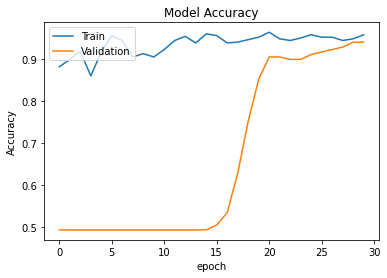

In [ ]:
plot_accuracy(model_history)
plt.show()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

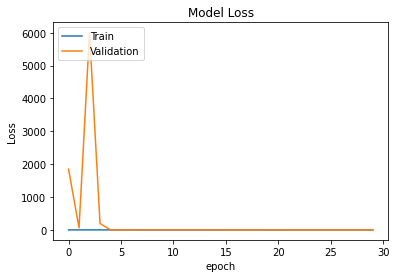

In [ ]:
plot_loss(model_history)
plt.show()

In [ ]:
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8194

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print('Confusion Matrix:', matrix)
print('Classification Report:', classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Confusion Matrix: [[76  8]
 [ 2 84]]
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.90      0.94        84
           1       0.91      0.98      0.94        86

    accuracy                           0.94       170
   macro avg       0.94      0.94      0.94       170
weighted avg       0.94      0.94      0.94       170



**Visualization**

In [ ]:
import tensorflow as tf
import keras.backend as K

K.set_learning_phase(0)
logits = keras.models.Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)
def visualize():
  print("Random Train Example")
  idx = rn.randint(0,len(X_train)-1)
  x_var = K.variable(X_train[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

  print("Random Test Example")
  idx = rn.randint(0,len(X_test)-1)
  x_var = K.variable(X_test[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

ValueError: ignored

In [ ]:
visualize()